# Numerical solution of the TOV equations for CGF stars  
  
This Sagemath notebook does calculations for the paper *Dark matter stars*.

## Preamble

In [1]:
%display latex
LE = lambda latex_string: LatexExpr(latex_string);

In [2]:
from timeit import default_timer as timer
# start=timer()
# end=timer()

In [3]:
from mpmath import mp
from mpmath import mpf,mpc
import sage.libs.mpmath.all as a
mp.pretty = True

## Code to set floating point precision

**mpf(x)**  converts sage floating point numbers to mp numbers  
**Reals(x)** or **myR(x)** converts mp numbers to sage

setting **mp.dps** tells mpmath to use decimal precision **mp.dps** or a small amount more  
Sagemath decimal precision is set to mpmath decimal precision + 3

In [4]:
def set_precision(decimal_precision=20):
    global RealNumber,Reals,myR,sage_binary_precision,sage_decimal_precision
    mp.dps = decimal_precision
    binary_precision=mp.prec
    sage_binary_precision=binary_precision+10
    sage_decimal_precision = floor(sage_binary_precision/log(10,2))
    Reals = RealField(sage_binary_precision)
    RealNumber = Reals
    myR = Reals
    pretty_print("mp.dps = ",mp.dps,"   mp decimal precision = ", floor(mp.prec/log(10,2)),\
                        "     sage decimal precision = ", sage_decimal_precision )
set_precision(decimal_precision=20)

'mp.dps = ' 20 '   mp decimal precision = ' 21 '     sage decimal precision = ' 24

## Numerical parameters

Copied from *A theory of the dark matter*

In [5]:
rhohat_EW_val = 7.974153922874089
c_b_val = 0.24289366755876735
#
g2_val   =  0.4262847210445738
lambda_val = 0.5080829235055462
#
lam2_val = lambda_val^2
rhohat_EW_inv_val = 1/rhohat_EW_val 
#
rhohat_EW_mpf = mpf(7.974153922874089)
c_a_val = 0.9924810876684255

CGF scale

In [6]:
m,kg,J,GeV,Mpc,pc,km = var('m,kg,J,GeV,Mpc,pc,km')
s = var('s',domain='positive'); assume(s,'real')
G     = RDF(6.67430e-11)*m^3*kg^(-1)* s^(-2)
c     = RDF(2.99792458e8) * m * s^(-1)
hbar  = RDF(1.054571817e-34)*J*s
H0    = RDF(6.74e1) *km * s^(-1) * Mpc^(-1)
Msun  = RDF(1.9884e30)*kg
GMsun = RDF(1.3271244e20)*m^3/s^2
m_Higgs = RDF(125.10)*GeV
#
J_per_GeV  = RDF(1e9*1.602176634e-19)*J/GeV
J_per_kg   =   RDF(2.99792458e8^2) *J/kg
m_per_pc = RDF(3.085677581 * 1e16) * m/pc
GeV_per_kg   = J_per_kg/J_per_GeV 
pc_per_Mpc = RDF(1e6) *pc/Mpc
m_per_km = RDF(1e3) *m/km
#
m_Higgs_kg = m_Higgs/GeV_per_kg
#
rho_b = m_Higgs_kg^4/(hbar*c/J_per_kg )^3
r_b_s= (4*RDF(pi)*G*rho_b)^(-1/2)
r_b_m = r_b_s*c
m_b_kg = (r_b_m/G)*c^2
m_b_J = m_b_kg*J_per_kg
m_b_solar = m_b_kg/Msun
pretty_print(LE(r"\frac{G M_S}{G} = "),GMsun/G)
pretty_print(LE(r"\rho_b = "),rho_b)
pretty_print(LE(r"r_b = "),r_b_s,LE(r" = "),r_b_m)
pretty_print(LE(r"m_b = "),m_b_kg,LE(r" = "),m_b_solar,LE(r"M_{\odot} = "), m_b_J)
#print("rho_b = ", rho_b)
#print("r_b = ", r_b_s, " = ", r_b)
#print("m_b = ", m_b, " = ", m_b_J)

\frac{G M_S}{G} =  (1.988409870698051e+30)*kg

\rho_b =  (5.682491786274899e+28)*kg/m^3

r_b =  (1.4485143361532907e-10)*s  =  0.04342536732836333*m

m_b =  (5.84762054071815e+25)*kg  =  2.9408673007031534e-05 M_{\odot} =  (5.255579244258227e+42)*J

In [7]:
pretty_print(LE(r"c_a= "), RDF(c_a_val),\
             LE(r"\qquad \pi c_a^{1/2} = "), RDF(pi*c_a_val^(1/2)),\
             LE(r"\qquad\pi c_a^{3/2} = "), RDF(pi*c_a_val^(3/2)))
pretty_print(LE(r"\frac{3\pi c_a^{5/2}}{4} = "), RDF(3*pi*c_a_val^(5/2)/4))

c_a=  0.9924810876684255 \qquad \pi c_a^{1/2} =  3.1297596889937487 \qquad\pi c_a^{3/2} =  3.1062273002733085

\frac{3\pi c_a^{5/2}}{4} =  2.312153887140458

## Code

The TOV equations form an ode with independent variable $\hat r$ and dependent variables $\hat p$, $\hat m$, $\hat e$.  

There are two odes:
+ an ode for the core, using the high density equation of state,
+ an ode for the outer shell, using the low density equation of state.

### TOV equations

In [8]:
m, E_tot, rho,p,r,G= var('m,E_tot,rho,p,r,G')
dpdr_sym = var('dpdr_sym',latex_name=r"\frac{dp}{dr}")
dmdr_sym = var('dmdr_sym',latex_name=r"\frac{dm}{dr}")
dEdr_sym = var('dEdr_sym',latex_name=r"\frac{dE_{tot}}{dr}")
#
dpdr = -(rho+p)*(G*m+4*pi*G*r^3*p)/(r*(r-2*G*m)); dpdr
dmdr = 4*pi*r^2*rho
dEdr = 4*pi*rho*r^2*(r/(r-2*G*m))^(1/2)
#dEdr = 4*pi*rho*r^2*sqrt(r/(r-2*G*m))
pretty_print(LE(r"\text{TOV equations} \qquad"),\
    dpdr_sym," = ",dpdr,LE(r"\qquad"), dmdr_sym," = ",dmdr,LE(r"\qquad"),dEdr_sym," = ",dEdr)

\text{TOV equations} \qquad dpdr_sym ' = ' (4*pi*G*p*r^3 + G*m)*(p + rho)/((2*G*m - r)*r) \qquad dmdr_sym ' = ' 4*pi*r^2*rho \qquad dEdr_sym ' = ' 4*pi*r^2*rho*sqrt(-r/(2*G*m - r))

In [9]:
mhat = var('mhat',latex_name=r"\hat m")
phat = var('phat',latex_name=r"\hat p")
rhohat = var('rhohat',latex_name=r"\hat \rho")
rhat = var('rhat',latex_name=r"\hat r")
ehat = var('ehat',latex_name=r"\hat e")
r_b,m_b= var('r_b,m_b')
dmhatdrhat_sym = var('dmhatdrhat_sym',latex_name=r"\frac{d\hat m}{d\hat r}")
dehatdrhat_sym = var('dehatdrhat_sym',latex_name=r"\frac{d\hat e}{d\hat r}")
dphatdrhat_sym = var('dphatdrhat_sym',latex_name=r"\frac{d\hat p}{d\hat r}")
#
rho = rhohat/(4*pi*G*r_b^2)
p   = phat/(4*pi*G*r_b^2)
m   = mhat*r_b/G
E_tot = ehat *r_b/G
r   = rhat*r_b
pretty_print(LE(r"\text{change to dimensionless variables}\qquad"),\
    LE(r"r = "),r,LE(r"\qquad \rho = "),rho,LE(r"\qquad p = "),p,\
    LE(r"\qquad m = "),m,LE(r"\qquad E_{tot} = "),E_tot)
print('\n')
#
dmhatdrhat = dmdr.subs(m=m,p=p,rho=rho,r=r) * diff(r,rhat)/diff(m,mhat)
dphatdrhat = (dpdr.subs(m=m,p=p,rho=rho,r=r) * diff(r,rhat)/diff(p,phat)).simplify_full()
dehatdrhat = (dEdr.subs(m=m,p=p,rho=rho,r=r) * diff(r,rhat)/diff(E_tot,ehat)).simplify_full()
pretty_print(LE(r"\text{dimensionless TOV equations}\qquad"),\
    dphatdrhat_sym," = ",dphatdrhat, LE(r"\qquad"),\
    dmhatdrhat_sym," = ",dmhatdrhat,LE(r"\qquad"),\
    dehatdrhat_sym," = ",dehatdrhat)

\text{change to dimensionless variables}\qquad r =  r_b*rhat \qquad \rho =  1/4*rhohat/(pi*G*r_b^2) \qquad p =  1/4*phat/(pi*G*r_b^2) \qquad m =  mhat*r_b/G \qquad E_{tot} =  ehat*r_b/G

\text{dimensionless TOV equations}\qquad dphatdrhat_sym ' = ' (phat^2*rhat^3 + mhat*phat + (phat*rhat^3 + mhat)*rhohat)/(2*mhat*rhat - rhat^2) \qquad dmhatdrhat_sym ' = ' rhat^2*rhohat \qquad dehatdrhat_sym ' = ' rhat^2*rhohat*sqrt(-rhat/(2*mhat - rhat))

### Prepare the core ode

In [10]:
c_b = var('c_b')
rhohat_EW = var('rhohat_EW',latex_name=r"\hat \rho_{EW}")
#
phat = (rhohat - c_b*rhohat_EW)/3
pretty_print(LE(r"\text{high density equation of state}\qquad"),LE(r"\hat p = "),phat)

\text{high density equation of state}\qquad \hat p =  -1/3*c_b*rhohat_EW + 1/3*rhohat

In [11]:
drhohatdrhat_sym = var('drhohatdrhat_sym',latex_name=r"\frac{d\hat \rho}{d\hat r}")
#
drhohatdrhat = (dphatdrhat.subs(phat=phat)/diff(phat,rhohat)).simplify_rational()
pretty_print(LE(r"\text{substitute for }\hat p\qquad"),\
    drhohatdrhat_sym," = ",drhohatdrhat)

\text{substitute for }\hat p\qquad drhohatdrhat_sym ' = ' 1/3*(c_b^2*rhat^3*rhohat_EW^2 + 4*rhat^3*rhohat^2 + 12*mhat*rhohat - (5*c_b*rhat^3*rhohat + 3*c_b*mhat)*rhohat_EW)/(2*mhat*rhat - rhat^2)

#### change variables  

The density $\hat \rho$ decreases monotonically with the radius $\hat r$ 
so we can take $\hat \rho$ as the independent variable in the ode.  
This allows integrating the ode from the initial condition $\hat \rho(0)$
down to $\hat \rho = \hat \rho_{EW}$ which is the density at the outer
surface of the core.  
The ode solver wants the independent variable to increase, so we use
$$
u = \frac{\hat \rho_{EW}}{\hat \rho}
\qquad
u_0 \le u \le 1
$$
as independent variable.  To simplify the ode, we change dependent variables to
$$
w = \frac{\hat m}{\hat\rho_{EW}\hat r^3}
\qquad
x=\hat r^2
\qquad
z = \frac{\hat e}{\hat\rho_{EW}}
$$

In [12]:
rhohat_EW_inv = var('rhohat_EW_inv',latex_name=r"\hat \rho_{EW}^{-1}")
u = var('u')
w = var('w')
x = var('x')
z = var('z')
#
dudrhat_sym = var('dudrhat_sym',latex_name=r"\frac{du}{d\hat r}")
dwdrhat_sym = var('dwdrhat_sym',latex_name=r"\frac{dw}{d\hat r}")
dzdrhat_sym = var('dzdrhat_sym',latex_name=r"\frac{dz}{d\hat r}")
dwdx_sym = var('dwdx_sym',latex_name=r"\frac{dw}{dx}")
dzdx_sym = var('dzdx_sym',latex_name=r"\frac{dz}{dx}")
dxdu_sym = var('dxdu_sym',latex_name=r"\frac{dx}{du}")
dwdu_sym = var('dwdu_sym',latex_name=r"\frac{dw}{du}")
dzdu_sym = var('dzdu_sym',latex_name=r"\frac{dz}{du}")
#
mhat = w*rhat^3*rhohat_EW
ehat = z*rhohat_EW
rhohat = rhohat_EW/u
#
dwdrhat=((dmhatdrhat.subs(mhat=mhat,rhohat=rhohat)- diff(mhat,rhat))/diff(mhat,w)).simplify_full()
dudrhat= (drhohatdrhat.subs(mhat=mhat,rhohat=rhohat)/diff(rhohat,u)).simplify_full()
dzdrhat = (dehatdrhat.subs(mhat=mhat,rhohat=rhohat)/rhohat_EW).simplify_full()
rhohat_EW = 1/rhohat_EW_inv
dudrhat = (dudrhat.subs(rhohat_EW=rhohat_EW)).simplify_rational()
#pretty_print(dwdrhat_sym," = ",dwdrhat,LE(r"\qquad"),dudrhat_sym," = ",dudrhat)
#
rhat = sqrt(x)
#
dwdx = ((dwdrhat.subs(rhat=rhat)*diff(rhat,x)).simplify_full()).factor()
dzdx = ((dzdrhat.subs(rhat=rhat)*diff(rhat,x)).simplify_full()).factor()
dxdu = ((1/(dudrhat.subs(rhat=rhat)*diff(rhat,x))).simplify_full()).factor()
pretty_print(LE(r"\hat \rho = "),rhohat, LE(r"\qquad\hat r = "),rhat,LE(r"\qquad\hat m = "),mhat)
print('\n')
pretty_print(dwdx_sym," = ",dwdx,LE(r"\qquad"),dzdx_sym," = ",dzdx)
print('\n')
pretty_print(dxdu_sym," = ",dxdu,LE(r"\qquad"),dwdu_sym," = ",dwdx_sym *dxdu_sym,\
             LE(r"\qquad"),dzdu_sym," = ",dzdx_sym *dxdu_sym)

\hat \rho =  rhohat_EW/u \qquad\hat r =  sqrt(x) \qquad\hat m =  rhat^3*rhohat_EW*w

dwdx_sym ' = ' -1/2*(3*u*w - 1)/(u*x) \qquad dzdx_sym ' = ' 1/2*sqrt(x)*sqrt(-1/(2*rhohat_EW*w*x - 1))/u

dxdu_sym ' = ' -6*(2*w*x - rhohat_EW_inv)/((c_b*u - 3*u*w - 1)*(c_b*u - 4)) \qquad dwdu_sym ' = ' dwdx_sym*dxdu_sym \qquad dzdu_sym ' = ' dxdu_sym*dzdx_sym

#### make ode derivatives into functions callable by the ode solver

$\frac{dw}{du}$, $\frac{dx}{du}$, $\frac{dz}{du}$

In [13]:
dwdu = ((dwdx*dxdu).simplify_full()).factor()
dwdu_num = dwdu.subs(rhohat_EW_inv=rhohat_EW_inv_val,c_b=c_b_val)
dxdu_num = dxdu.subs(rhohat_EW_inv=rhohat_EW_inv_val,c_b=c_b_val)
#
dwdu_fn=fast_callable(dwdu_num,vars=[u,w,x])
dxdu_fn=fast_callable(dxdu_num,vars=[u,w,x])
#
dzdu_fn = lambda u,w,x: (mp.sqrt(x/(1-2*rhohat_EW_mpf*w*x))/(2*u)) *dxdu_fn(u,w,x)

#### prepare the initial condition  
  
The ode is singular at $\hat r=0$ so start the ode at $u= u_0(1+\epsilon)$.

In [14]:
uu0,xx,bb_1,aa_1 = var('uu0,xx,bb_1,aa_1')
usubs = uu0*(1+xx)
wsubs = (1+aa_1*xx)/(3*uu0)
xsubs = bb_1*xx
rhs_w =( ( dwdu.subs(u==usubs,w==wsubs,x== xsubs) ).simplify_rational() ).subs(xx==0)
rhs_x =( ( dxdu.subs(u==usubs,w==wsubs,x== xsubs) ).simplify_rational() ).subs(xx==0)
sol = solve([diff(wsubs,xx) == rhs_w, diff(xsubs,xx) == rhs_x],aa_1,bb_1,solution_dict=True)
a_1 = sol[0][aa_1]
b_1 = sol[0][bb_1]
pretty_print(LE(r"u = u_0(1+\epsilon)"),LE(r"\qquad w = \frac{1+a_1\epsilon}{3 u_0}"),\
    LE(r"\qquad x = b_1 \epsilon \qquad z = \frac13 \hat\rho_0\hat r^3 = \frac{x^{3/2}}{3u_0} "))
print('\n')
pretty_print(LE(r"a_1 = "),a_1,LE(r"\qquad b_1 = "),b_1)
a_1_fn = fast_callable(a_1.subs(c_b == c_b_val,rhohat_EW_inv == rhohat_EW_inv_val),vars=[uu0])
b_1_fn = fast_callable(b_1.subs(c_b == c_b_val,rhohat_EW_inv == rhohat_EW_inv_val),vars=[uu0])

u = u_0(1+\epsilon) \qquad w = \frac{1+a_1\epsilon}{3 u_0} \qquad x = b_1 \epsilon \qquad z = \frac13 \hat\rho_0\hat r^3 = \frac{x^{3/2}}{3u_0}

a_1 =  -3/5 \qquad b_1 =  6*rhohat_EW_inv/(c_b^2*uu0^2 - 6*c_b*uu0 + 8)

#### define a function to convert ode-solver output to star data  
  
The ode-solver outputs **y=[w,x,z]**.  
The star data is ($\hat r$, $\hat m$, $\hat e$, $\hat \rho$, $\hat p$)

In [15]:
mhat_wx= mhat.subs(rhat=rhat);mhat_wx
mhat_wx_num= mhat_wx.subs(rhohat_EW = rhohat_EW_val)
mhat_wx_fn = fast_callable(mhat_wx_num,vars=[w,x])
#
rhat_x_fn= fast_callable(rhat,vars=[x])
#
rhohat_num = rhohat.subs(rhohat_EW = rhohat_EW_val); rhohat_num
rhohat_u_fn = fast_callable(rhohat_num,vars=[u])
#
phat1 = phat.subs(rhohat=rhohat)
phat_num= phat1.subs(rhohat_EW=rhohat_EW_val,c_b=c_b_val); phat_num
phat_u_fn = fast_callable(phat_num,vars=[u])
#
pretty_print(LE(r"\hat r = "),rhat,LE(r"\qquad\hat m = "),mhat_wx,\
             LE(r"\qquad\hat e = z \hat \rho_{EW}"),LE(r"\qquad\hat \rho = "),\
            rhohat, LE(r"\qquad\hat p = "),phat)
#
def rhat_mhat_ehat_rhohat_phat(u,y):
    w=y[0]
    x=y[1]
    z=y[2]
    ehat = z*rhohat_EW_mpf
    return (rhat_x_fn(x),mhat_wx_fn(w,x),ehat,rhohat_u_fn(u),phat_u_fn(u))

\hat r =  sqrt(x) \qquad\hat m =  rhohat_EW*w*x^(3/2) \qquad\hat e = z \hat \rho_{EW} \qquad\hat \rho =  rhohat_EW/u \qquad\hat p =  -1/3*c_b*rhohat_EW + 1/3*rhohat

#### **(rhohat_norm_0_actual, core_ode) = make_core_ode(rhohat_norm_0)**

**rhohat_norm_0** $ = \hat \rho_{norm}(0)$  is the initial condition at $\hat r=0$.  
$$
\hat \rho_{norm} = {\frac{\hat \rho}{\hat \rho_{EW}}} = \frac1{u}
$$

**rhohat_norm_0_actual** = $(1 - \epsilon)\hat \rho_{norm}(0)$ is the actual initial value given to the ode-solver.  
  
**core_ode** $\colon \hat \rho_{norm} \mapsto (\hat r,\hat m,\hat e,\hat \rho, \hat p)$ is the solution of the ode for 
$$
\hat \rho_{norm} \le (1 - \epsilon)\hat \rho_{norm}(0)
$$
  
The actual ode-solver is &emsp; **[w,x,z] = the_odefun(u)** for
$$
 (1+\epsilon) u_0 \le u
$$

In [16]:
ode_tol = None
ode_degree = None
epsilon=mpf(1e-20)
F_core = lambda u,y: [dwdu_fn(u,y[0],y[1]),dxdu_fn(u,y[0],y[1]),dzdu_fn(u,y[0],y[1])]
#
def make_core_ode(rhohat_norm_0):
    rhohat_norm_0_actual = mpf(rhohat_norm_0) - epsilon
    u0 = mpf(1/rhohat_norm_0_actual)
    a_1_val = a_1_fn(u0)
    b_1_val = b_1_fn(u0)
    w0 = mpf((1-a_1_val*epsilon)/(3*u0))
    x0=  mpf(b_1_val*epsilon)
    z0 = mp.power(x0,3/2)/(3*u0)
    the_odefun = mp.odefun(F_core,u0,[w0,x0,z0],tol=ode_tol,degree=ode_degree)
    core_ode = lambda rhohat_norm: rhat_mhat_ehat_rhohat_phat(1/rhohat_norm,\
                    the_odefun(1/rhohat_norm))
    return (rhohat_norm_0_actual,core_ode)

### Prepare the shell ode  
  
The low density equation of state is expressed implicitly
$$
\hat \rho, \hat p = \hat \rho(k^2), \hat p(k^2)
\qquad
\frac12 \ge k^2 \ge0
\qquad
\hat \rho(1/2) = \hat\rho_{EW}
\qquad
\hat \rho(0) =  0
$$
The functions $\hat \rho(k^2)$, $\hat p(k^2)$ are expressed by a series of formulas listed in Table 2 of *A theory of the dark matter*.  
The formulas involve the the ratio $K/E$ where $K(k)$ and $E(k)$ are the complete elliptic integrals.  $k^2$ is the *elliptic parameter*.  
The usual notation is $m=k^2$.  
  
The TOV equations are solved with 
$$
\text{independent variable}\quad \sigma = 1-2m
\qquad
\text{dependent variables}\quad \hat r,\,\hat m,\,\hat e
$$
During the preparation of the ode it is convenient to use
$$
s = -\ln m
\qquad
\frac{d}{ds} = - m \frac{d}{dm}  = \frac{1-\sigma}{2}\frac{d}{d\sigma} 
$$

#### code to define functions of $m$
  
The following code enters the Table 2 formulas as SageMath symbolic expressions.

In [17]:
latex_name={}
latex_name['alpha2_b2']     = r"\alpha^2\langle b^2\rangle"
latex_name['alpha2_mu2']   = r"\alpha^2\mu^2"
latex_name['alpha4_ECGF']   = r"\alpha^{4} E_{\mathrm{EW}}"
latex_name['alpha2_ahat2']   = r"\alpha^2 \hat a^2"
latex_name['rhohat']   = r"\hat \rho"
latex_name['phat'] = r"\hat p"
latex_name['lam2'] = r"\lambda^2"
latex_name['g2'] = r"g^2"
latex_name['EoverK'] = r"\frac{E}{K}"
latex_name['m'] = r"m"
for vstr,form in latex_name.items():
    var(vstr,latex_name=latex_name[vstr])
#
formula={}
formula['alpha2_b2']        = m-1+EoverK
formula['alpha2_mu2']       = 1-2*m
formula['alpha4_ECGF']       = m*(1-m)/2
formula['alpha2_ahat2']     = 3*alpha2_b2/2 + (4*lam2/g2)*alpha2_mu2
formula['rhohat']     = ((3/g2)*alpha4_ECGF+(9/(32*lam2))*alpha2_b2^2)/alpha2_ahat2^2
formula['phat']     = ( (1/g2)*(alpha4_ECGF-alpha2_mu2*alpha2_b2)\
                       - (9/(32*lam2))*alpha2_b2^2 )/alpha2_ahat2^2
pretty_print("formulas from Table 2")
print('\n')
for vstr,form in formula.items():
    pretty_print(LE(latex_name[vstr]),' = ', formula[vstr], hold= True)
    print('\n')

'formulas from Table 2'

\alpha^2\langle b^2\rangle ' = ' EoverK + m - 1

\alpha^2\mu^2 ' = ' -2*m + 1

\alpha^{4} E_{\mathrm{EW}} ' = ' -1/2*(m - 1)*m

\alpha^2 \hat a^2 ' = ' 3/2*alpha2_b2 + 4*alpha2_mu2*lam2/g2

\hat \rho ' = ' 3/32*(3*alpha2_b2^2/lam2 + 32*alpha4_ECGF/g2)/alpha2_ahat2^2

\hat p ' = ' -1/32*(9*alpha2_b2^2/lam2 + 32*(alpha2_b2*alpha2_mu2 - alpha4_ECGF)/g2)/alpha2_ahat2^2

Next, substitutions are made in the formulas to define functions 
$$
m, \, E/K \mapsto \hat\rho, \,\hat p,\, \frac{d \hat p}{d\sigma}
$$
For efficiency, the elliptic integrals $E,\,K$ will be calculated separately.

In [18]:
expr={}
for var_str in list(formula.keys()):
    formula_expanded = eval(preparse(str(formula[var_str])))
    locals()[var_str] = formula_expanded
    expr[var_str] = formula_expanded

mdot = -m
EoverKdot = 1/2 -EoverK +EoverK^2/(2*(1-m))
dot = lambda y: mdot*y.diff(m) + EoverKdot*y.diff(EoverK)
#
expr['dphatds'] = dphatds = dot(phat)

expr_n={}
for var_str,expre in expr.items():
    expr_n[var_str] = expre.subs(lam2==lam2_val,g2==g2_val)

fast={}
for var_str,expre in expr_n.items():
    fast[var_str] = fast_callable(expre,vars=[m,EoverK])
pretty_print(LE(r"\text{fast_callable versions of}"),list(fast.keys()))

\text{fast_callable versions of} ['alpha2_b2',
 'alpha2_mu2',
 'alpha4_ECGF',
 'alpha2_ahat2',
 'rhohat',
 'phat',
 'dphatds']

define functions
$$
m \mapsto (\hat \rho,\hat p, d\hat p/ds)
\qquad
m \mapsto (\hat \rho,\hat p)
$$

In [19]:
def rhohat_phat_dphatds(m_arg):
    m_val = mpf(m_arg)
    KoverE_val = mp.ellipe(m_val)/mp.ellipk(m_val)
    rhohat_val = fast['rhohat'](m_val,KoverE_val)
    phat_val   = fast['phat'](m_val,KoverE_val)
    dphatds_val = fast['dphatds'](m_val,KoverE_val)
    return (rhohat_val,phat_val,dphatds_val)

In [20]:
def rhohat_phat(m_arg):
    m_val = mpf(m_arg)
    KoverE_val = mp.ellipe(m_val)/mp.ellipk(m_val)
    rhohat_val = fast['rhohat'](m_val,KoverE_val)
    phat_val   = fast['phat'](m_val,KoverE_val)
    return [rhohat_val,phat_val]

define the function that provides the derivatives of the dependent variables to the ode solver.
$$
\sigma, y \mapsto \left[ \frac{d\hat r}{d\sigma}, \,\frac{d\hat m}{d\sigma},\,\frac{d\hat e}{d\sigma} \right ]
$$

In [21]:
def F_shell(sigma,y_arg):
    rhat = y_arg[0]
    mhat = y_arg[1]
    m = (1-sigma)/2
    (rhohat,phat,dphatds) = rhohat_phat_dphatds(m)
    drhatds = -dphatds*(rhat-2*mhat)/((rhohat+phat)*(mhat/rhat+rhat^2*phat))
    drhatdsigma = drhatds/(1-sigma)
    dmhatdsigma = rhat^2*rhohat*drhatds/(1-sigma)
    dehatdrhat = rhohat*rhat^2/mp.sqrt(1-2*mhat/rhat)
    dehatdsigma = dehatdrhat*drhatdsigma
    return [drhatdsigma,dmhatdsigma,dehatdsigma]

### How stars are represented

A **star** is generated from an initial condition $\hat \rho_{norm}(0)$.  
  
For $\hat \rho_{norm}(0)>1$, first the **core_ode** is constructed and solved to the endpoint $u=1$ to get the core radius, mass, and energy.  These are then used as initial conditions for the **shell_ode** which is solved to the endpoint $\sigma=1$ to get the star radius, mass, and energy.

For $\hat \rho_{norm}(0)\le 1$, only the **shell_ode** is constructed and run.
  
The results are stored in a **star** which is a dictionary with two keys, **'data'** and **'ode'**.
+ **star['data']** is a dictionary with keys
    + **'central density'** 
    + **'mass'** 
    + **'radius'**
    + **'energy'**
    + **'core mass'**
    + **'core radius'**
    + **'core energy'**                
    + **'core density'**                
    + **'core pressure'**                
    + **'core profile'**
    + **'shell profile'**
+ **star['ode']** is a dictionary with keys
    + **'core ode'**
    + **'shell ode'**
    + **'initial value'**

Numerical values are mpf floating point numbers.  **'core profile'** and **'shell profile'** are not used here.  Their values would be the intermediate values of the TOV solution for the star.  Here we only calculate at the ode endpoints: the data at the boundary of the core and at the boundary of the star.

### How stars are generated and stored

The object is to generate a set of stars more or less evenly spaced on the star curve in the $M$, $R$ plane.  
  
The even space is more or less accomplished by an algorithm.
  
The data is collected in subsets to allow for twiddling the decimal precision and the spacing parameters.  

A subset of stars is called a **star_set**.  This is a dictionary of stars.  The dictionary key is the star's initial value
converted to a string.  The value is a **star**.
+ **star_set[skey] = star**

The **star_set**s are stored in two lists, one for the stars with cores, the other for the coreless stars.

#### code to make a store with core

**star** = **make_star(** $\hat\rho_{norm}(0)$**)**

In [22]:
skey = lambda x : "{:.8e}".format(RDF(x))

In [23]:
ode_tol = None
ode_degree = None
epsilon=mpf(1e-20)
#
F_core = lambda u,y: [dwdu_fn(u,y[0],y[1]),dxdu_fn(u,y[0],y[1]),dzdu_fn(u,y[0],y[1])]
#
def make_star(rhohat_norm_0_arg,return_ode=False):
    rhohat_norm_0 = mpf(rhohat_norm_0_arg)
    star_key = skey(rhohat_norm_0)
# make core
    rhohat_norm_0_actual = rhohat_norm_0 - epsilon
    u0 = mpf(1/rhohat_norm_0_actual)
    a_1_val = a_1_fn(u0)
    b_1_val = b_1_fn(u0)
    w0 = mpf((1-a_1_val*epsilon)/(3*u0))
    x0=  mpf(b_1_val*epsilon)
    z0 = mp.power(x0,3/2)/(3*u0)
    the_odefun = mp.odefun(F_core,u0,[w0,x0,z0],tol=ode_tol,degree=ode_degree)
    core_ode = lambda rhohat_norm: \
                rhat_mhat_ehat_rhohat_phat(1/rhohat_norm,the_odefun(1/rhohat_norm))
    core_data = core_ode(1)
# make shell
    y_init = core_data[0:3]
    shell_odefun =  mp.odefun(F_shell,0,y_init,tol=ode_tol,degree=ode_degree)
    shell_ode = lambda m: tuple(shell_odefun(mpf(1-2*m)) + rhohat_phat(m))
    shell_data = shell_ode(0)
# store star
    data={}
    data['central density'] = rhohat_norm_0*rhohat_EW_mpf
    data['radius'] = shell_data[0]
    data['mass']   = shell_data[1]
    data['energy'] = shell_data[2]
#    
    data['core radius']   = core_data[0]
    data['core mass']     = core_data[1]
    data['core energy']   = core_data[2]
    data['core density']  = core_data[3]
    data['core pressure'] = core_data[4]
#   data['core_profile']=None
#   data['shell_profile']=None
    ode={}
    if return_ode:
        ode['core ode'] = core_ode
        ode['shell ode'] = shell_ode
    ode['initial value'] = rhohat_norm_0_actual
    star={}
    star['star key'] =star_key
    star['data']     =data
    star['ode']      =ode
    return star

#### code to adaptively sample parameter space
  
The last 3 points are used to calculate the radius of curvature $A/B$ (radius of the circle passing through the points).  
  
At the beginning of a run, 3 stars have to be generated to initialize the adaptive algorithm.
  
The spacing in the $\hat M$-$\hat R$ plane to the next point is
$$
\frac{A}{A+c B} \epsilon'
$$
If the radius of curvature is large, the spacing is $\epsilon'$.  If the radius of curvature is small, the spacing is $\frac{A}{cB} \epsilon'$.  
  
Then linear extrapolation gives the parameter step that will give this spacing.

In [24]:
def next():
    q10 = p[1]-p[0]
    q21 = p[2]-p[1]
    n10 = norm(q10)
    n21 = norm(q21)
    n20 = norm(q21+q10)
    A = n10*n21*n20
    B = 2*abs(q10[0]*q21[1]-q10[1]*q21[0])
#  A/B is the radius of curvature
#    1 try R = A/(A+B)
#    2 try R = A/(A+0.5*B)
    R = A/(A+0.25*B)
    return R*(t[2]-t[1])/n21

In [25]:
def initialize_adaptive(rhohat_norms):
    global star_set,p,t
    if len(rhohat_norms) != 3:
        print("ERROR: NEED 3 stars")
        return
    this_star_set={}
    p=[]
    t=[]
    print("star_set[{0}]".format(len(star_set)))
    for rhohat_norm_0 in rhohat_norms:
        start = timer()
        star = make_star(rhohat_norm_0 )
        end = timer()
        star_key = star['star key']
        this_star_set[star_key]=star
        star_data = star['data']
        print_star(star_key,star_data,time=end-start)
        rhat = star_data['radius']
        mhat = star_data['mass']
        p.append(vector([Reals(mhat),Reals(rhat)]))
        t.append(Reals(rhohat_norm_0))
    star_set.append(this_star_set)
def make_stars_adaptive(rhohat_norm_max=10,eps=.1):
    global star_set,p,t
    this_star_set ={}
    print("star_set[{0}]".format(len(star_set)))
    rhohat_norm_0 = t[2]
    while rhohat_norm_0 <= rhohat_norm_max:
        rhohat_norm_0 = rhohat_norm_0+eps*next()
        start = timer()
        star = make_star(rhohat_norm_0)
        end = timer()
        star_key = star['star key']
        this_star_set[star_key]=star
        star_data = star['data']
        print_star(star_key,star_data,time=end-start)
        rhat = star_data['radius']
        mhat = star_data['mass']
        p.append(vector([Reals(mhat),Reals(rhat)]))
        p.pop(0)
        t.append(Reals(rhohat_norm_0))
        t.pop(0)
    star_set.append(this_star_set)

### code for coreless stars
  
For $\hat \rho_{norm}(0) \le 1$ the star has no core.  Only the shell ode is run.  
  
Again $\hat r =0$ is a singular point of the ode.  The initial condition is again shifted by $\epsilon$.
  
$$
\begin{gathered}
\sigma = \sigma_0+\epsilon
\\
c_1 = \hat r \frac{d\hat r}{d\sigma}_{/\sigma_0}
\qquad
\hat r^2 =  2 c_1 \epsilon
\\
\frac{d\hat p}{d \hat r} = -(\hat \rho_0+\hat p_0)
\left( \frac13 \hat\rho_0 +\hat p_0\right) \hat r
\qquad
\hat p = \hat p_0 - \hat \rho_0+\hat p_0)
\left( \frac13 \hat\rho_0 +\hat p_0\right) \frac12 \hat r^2
\\
\hat m = \hat e = \frac13 \hat \rho_0 \hat r^3
\end{gathered}
$$

In [26]:
ode_tol = None
ode_degree = None
epsilon=mpf(1e-20)
#
#
def make_coreless_star(m_0_arg,return_ode=False):
    if m_0_arg > 1/2:
        print('ERROR: star_key must be <= 1/2')
        return
    m_0 = mpf(m_0_arg)
#    m_0 = mpf(Reals(m_0_arg))
    star_key = skey(m_0)
#
    (rhohat_norm_0_actual,phat_s) = rhohat_phat(m_0)
    rhat_s = var('rhat_s',latex_name=r"\hat r")
    (rhohat_s_mpf,phat_s,dphatds_s) = rhohat_phat_dphatds(m_0)
    rhohat_s=Reals(rhohat_s_mpf)
    phat_s=Reals(phat_s)
    dphatds_s=Reals(dphatds_s)
    mhat_s = rhohat_s*rhat_s^3/3
    drhatds_s = -dphatds_s*(rhat_s-2*mhat_s)/((rhohat_s+phat_s)*(mhat_s/rhat_s+rhat_s^2*phat_s))
    c1 = mpf((rhat_s*drhatds_s).simplify_rational().subs(rhat_s =0))
    c1 = mp.sqrt(2*c1)
#
    m_0_actual = m_0*(1-c1*epsilon*epsilon)
    rhat_init = c1*epsilon
    mhat_init = rhohat_s*mp.power(rhat_init,3)/3
    ehat_init = mhat_init
    y_init = [rhat_init,mhat_init,ehat_init]
    sigma_init = mpf(1 - 2*m_0_actual)
    shell_odefun =  mp.odefun(F_shell,sigma_init,y_init,tol=ode_tol,degree=ode_degree)
    shell_ode = lambda m: tuple(shell_odefun(mpf(1-2*m)) + rhohat_phat(m))
    shell_data = shell_ode(0)
# store star
    data={}
    data['central density'] = rhohat_s_mpf
    data['radius'] = shell_data[0]
    data['mass']   = shell_data[1]
    data['energy'] = shell_data[2]
#   data['shell_profile']=None
    ode={}
    if return_ode:
        ode['shell ode'] = shell_ode
    ode['initial value'] = m_0_actual
    star={}
    star['star key'] =star_key
    star['data']     =data
    star['ode']      =ode
    return star

In [27]:
def initialize_adaptive_coreless(ms):
    global coreless_star_set,p,t
    if len(ms) != 3:
        print("ERROR: NEED 3 stars")
        return
    this_star_set={}
    p=[]
    t=[]
    print("coreless_star_set[{0}]".format(len(coreless_star_set)))
    for m_0 in ms:
        start = timer()
        star = make_coreless_star(m_0)
        end = timer()
        star_key = star['star key']
        this_star_set[star_key]=star
        star_data = star['data']
        print_star(star_key,star_data,time=end-start)
        rhat = star_data['radius']
        mhat = star_data['mass']
        p.append(vector([Reals(mhat),Reals(rhat)]))
        t.append(Reals(m_0))
    coreless_star_set.append(this_star_set)
def make_coreless_stars_adaptive(m_min=0.4,eps=.1):
    global coreless_star_set,p,t
    this_star_set ={}
    print("coreless_star_set[{0}]".format(len(coreless_star_set)))
    m_0 = t[2]
    while m_0 >= m_min:
        m_0 = m_0+eps*next()
        start = timer()
        star = make_coreless_star(m_0)
        end = timer()
        star_key = star['star key']
        this_star_set[star_key]=star
        star_data = star['data']
        print_star(star_key,star_data,time=end-start)
        rhat = star_data['radius']
        mhat = star_data['mass']
        p.append(vector([Reals(mhat),Reals(rhat)]))
        p.pop(0)
        t.append(Reals(m_0))
        t.pop(0)
    coreless_star_set.append(this_star_set)

#### code to initialize the adaptive algorithm from the last 3 stars in a star_set

In [28]:
def set_pt(a_star_set):
    global p,t
    pf = []
    tf = []
    for star_key in list(a_star_set.keys())[-3:]:
        star_data = a_star_set[star_key]['data']
        mass = star_data['mass']
        radius = star_data['radius']
        param = a_star_set[star_key]['ode']['initial value']
        tf.append(param)
        pf.append(vector([Reals(mass),Reals(radius)]))
    p = pf
    t = tf

#### code for printing and plotting

In [29]:
def print_star(star_key,star_data,time=0):
    rhat = star_data['radius']
    mhat = star_data['mass']
    ehat = star_data['energy']
    BE = ehat -mhat
    BEratio = BE/mhat    
    print(star_key,"r=%.6e" % rhat, "m=%.6e" % mhat, "e=%.6e" % ehat,"BE=%.6e" % BE, "BE/M=%.6e" % BEratio,"t=%.0f" % time)
#def print_star(star_key,star_data,time=0):
#    rhat = star_data['radius']
#    mhat = star_data['mass']
#    ehat = star_data['energy']
#    BE = ehat -mhat
#    BEratio = BE/mhat    
#    print("'" + star_key + "'"," rhat= %.6e" % rhat, " mhat= %.6e" % mhat, " ehat= %.6e" % ehat," BEhat= %.6e" % BE, " BE/M= %.6e" % BEratio,' time= ',round(time,1))
#    pretty_print("'" + star_key + "'", \
#        LE(r"\quad\hat r = "),"%.6e" % rhat, LE(r"\quad\hat m = "),\
#            "%.6e" % mhat, LE(r"\quad\hat e = "), "%.6e" % ehat,\
#        LE(r"\quad BE = "),"%.6e" % BE, LE(r"\quad BE/\hat m = "),\
#            "%.6e" % BEratio,LE(r"\quad"),'time = ',round(time,1))

In [30]:
def plots(star_dict,xstr,ystr,joined=True):
    if joined:
        the_plot = list_plot( [[star_data[xstr],star_data[ystr]]\
                        for star_key,star_data in star_dict.items()],\
                        marker=None,plotjoined=True,thickness=0.5)
    else:
        the_plot = list_plot( [[star_data[xstr],star_data[ystr]]\
                        for star_key,star_data in star_dict.items()],\
                        marker='.',size=10)
    return the_plot

In [31]:
def plot_stars(xstr,ystr):
    return list_plot( [[star_data[xstr],star_data[ystr]]\
                       for star_key,star_data in stars.items()],\
                        marker='.',size=10)
def plot_stars_joined(xstr,ystr):
    return list_plot( [[star_data[xstr],star_data[ystr]]\
                       for star_key,star_data in stars.items()],\
                        marker=None,plotjoined=True,thickness=0.5)

In [32]:
def plot_coreless_stars(xstr,ystr):
    return list_plot( [[star_data[xstr],star_data[ystr]]\
                       for star_key,star_data in coreless_stars.items()],\
                        marker='.',size=10)
def plot_coreless_stars_joined(xstr,ystr):
    return list_plot( [[star_data[xstr],star_data[ystr]]\
                       for star_key,star_data in coreless_stars.items()],\
                        marker=None,plotjoined=True,thickness=0.5)

## Plot equation of state

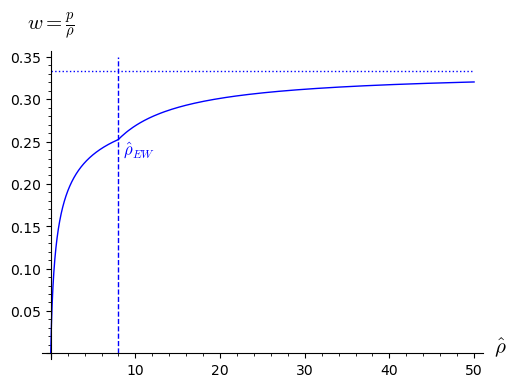

In [33]:
rho_low = lambda m: rhohat_phat(m)[0]
w_low = lambda m: rhohat_phat(m)[1]/ rhohat_phat(m)[0]
# p_low =lambda m: rhohat_phat(m)[1]
#
w_low_density_plot = parametric_plot((rho_low,w_low), (m,1e-6,0.5))
rhohat_max =50
w_high_density_plot = plot(lambda xx: (1-c_b_val*rhohat_EW_val/xx)/3,(rhohat_EW_val, rhohat_max))
#
plt = w_low_density_plot+w_high_density_plot
#plt += text(r"$\hat\rho_{EW}$",(rhohat_EW_val-1,-.02),fontsize="large")
plt += text(r"$\hat\rho_{EW}$",(rhohat_EW_val+2.5,.24),fontsize="large")
plt += line([(rhohat_EW_val,0),(rhohat_EW_val,0.35)],linestyle="--")
plt +=line([(0,1/3),(rhohat_max,1/3)],linestyle=":")
plt.set_aspect_ratio(2*rhohat_max )
plt.set_axes_range(ymax=.35)
plt.axes_labels([r"$\hat \rho$",r"$w=\frac{p}{\rho}$"])
show(plt,fontsize=10,axes_labels_size=1.5)
plt.save('plots/rhohat_w.pdf',dpi=600,fontsize=10,axes_labels_size=1.5)

## generate stars with cores

In [34]:
star_set=[]
initialize_adaptive([1.0001,1.0011,1.0021])

star_set[0]
1.00010000e+00 r=1.296425e+00 m=2.324147e-01 e=2.991668e-01 BE=6.675207e-02 BE/M=2.872110e-01 t=9
1.00110000e+00 r=1.296270e+00 m=2.323664e-01 e=2.991125e-01 BE=6.674607e-02 BE/M=2.872449e-01 t=8
1.00210000e+00 r=1.296115e+00 m=2.323182e-01 e=2.990582e-01 BE=6.674008e-02 BE/M=2.872788e-01 t=8


In [35]:
make_stars_adaptive(rhohat_norm_max=1e9,eps=.02)

star_set[1]
1.09387377e+00 r=1.282999e+00 m=2.281176e-01 e=2.943168e-01 BE=6.619929e-02 BE/M=2.901981e-01 t=7
1.19720666e+00 r=1.270457e+00 m=2.238962e-01 e=2.895208e-01 BE=6.562456e-02 BE/M=2.931026e-01 t=7
1.31989022e+00 r=1.258032e+00 m=2.194890e-01 e=2.844832e-01 BE=6.499422e-02 BE/M=2.961161e-01 t=6
1.46238263e+00 r=1.246289e+00 m=2.150529e-01 e=2.793804e-01 BE=6.432755e-02 BE/M=2.991243e-01 t=6
1.62513990e+00 r=1.235655e+00 m=2.107082e-01 e=2.743487e-01 BE=6.364054e-02 BE/M=3.020317e-01 t=6
1.80734628e+00 r=1.226476e+00 m=2.065668e-01 e=2.695175e-01 BE=6.295069e-02 BE/M=3.047474e-01 t=6
2.00469227e+00 r=1.219027e+00 m=2.027569e-01 e=2.650390e-01 BE=6.228216e-02 BE/M=3.071765e-01 t=6
2.20742739e+00 r=1.213444e+00 m=1.994188e-01 e=2.610852e-01 BE=6.166636e-02 BE/M=3.092304e-01 t=6
2.40080697e+00 r=1.209636e+00 m=1.966694e-01 e=2.578049e-01 BE=6.113555e-02 BE/M=3.108544e-01 t=6
2.57030402e+00 r=1.207268e+00 m=1.945460e-01 e=2.552554e-01 BE=6.070939e-02 BE/M=3.120567e-01 t=6
2.708708

## generate coreless stars

In [36]:
coreless_star_set=[]
initialize_adaptive_coreless([0.5,0.499,0.498])

coreless_star_set[0]
5.00000000e-01 r=1.296441e+00 m=2.324196e-01 e=2.991722e-01 BE=6.675267e-02 BE/M=2.872076e-01 t=11
4.99000000e-01 r=1.299815e+00 m=2.334598e-01 e=3.003398e-01 BE=6.688004e-02 BE/M=2.864735e-01 t=11
4.98000000e-01 r=1.303226e+00 m=2.344930e-01 e=3.014964e-01 BE=6.700343e-02 BE/M=2.857375e-01 t=11


In [37]:
make_coreless_stars_adaptive(m_min=0.01,eps=0.025)

coreless_star_set[1]
4.92774117e-01 r=1.321575e+00 m=2.397770e-01 e=3.073618e-01 BE=6.758479e-02 BE/M=2.818652e-01 t=11
4.87524670e-01 r=1.340742e+00 m=2.448846e-01 e=3.129496e-01 BE=6.806499e-02 BE/M=2.779472e-01 t=11
4.82258661e-01 r=1.360541e+00 m=2.498029e-01 e=3.182499e-01 BE=6.844708e-02 BE/M=2.740044e-01 t=11
4.76928416e-01 r=1.381030e+00 m=2.545698e-01 e=3.233070e-01 BE=6.873718e-02 BE/M=2.700131e-01 t=11
4.71558240e-01 r=1.402020e+00 m=2.591576e-01 e=3.280937e-01 BE=6.893606e-02 BE/M=2.660005e-01 t=11
4.66160607e-01 r=1.423382e+00 m=2.635528e-01 e=3.325991e-01 BE=6.904635e-02 BE/M=2.619830e-01 t=11
4.60741224e-01 r=1.445027e+00 m=2.677497e-01 e=3.368212e-01 BE=6.907144e-02 BE/M=2.579701e-01 t=11
4.55302500e-01 r=1.466891e+00 m=2.717467e-01 e=3.407616e-01 BE=6.901486e-02 BE/M=2.539676e-01 t=11
4.49845040e-01 r=1.488927e+00 m=2.755440e-01 e=3.444241e-01 BE=6.888014e-02 BE/M=2.499788e-01 t=11
4.44368505e-01 r=1.511102e+00 m=2.791426e-01 e=3.478132e-01 BE=6.867064e-02 BE/M=2.46005

In [38]:
set_precision(30)
Rhat_a = Reals(pi*sqrt(c_a_val))
c_M = Reals(pi*c_a_val^(3/2))
c_E = Reals((3*pi/4)*c_a_val^(5/2))
pretty_print(LE(r"\hat R_{asymp} = "),"{:.8f}".format(Rhat_a),\
             LE(r"\qquad\hat M_{asymp} = "),"{:.8f}".format(c_M),LE(r"\:\hat{\rho}(0)"),\
             LE(r"\qquad\hat{B}E_{asymp} = "),"{:.8f}".format(c_E),LE(r"\:\hat{\rho}(0)^2"))
this_star_set ={}
print("coreless_star_set[{0}]".format(len(coreless_star_set)))
for n in range(15):
    m_0 = 5e-3/2^n
    start = timer()
    star = make_coreless_star(m_0)
    end = timer()
    star_key = star['star key']
    this_star_set[star_key]=star
    star_data = star['data']
    print_star(star_key,star_data,time=end-start)
    central_density = Reals(star_data['central density'])
    mass = Reals(star_data['mass'])
    radius = Reals(star_data['radius'])
    energy = Reals(star_data['energy'])
    BE = energy-mass
    pretty_print(LE(r"\frac{R}{R_{asymp}}="), RDF(radius/Rhat_a),\
            LE(r"\qquad\frac{M}{M_{asymp}}="), RDF(mass/(c_M*central_density)),\
            LE(r"\qquad\frac{BE}{BE_{asymp}}="), RDF(BE/(c_E*central_density^2)))
coreless_star_set.append(this_star_set)
set_precision()

'mp.dps = ' 30 '   mp decimal precision = ' 31 '     sage decimal precision = ' 34

\hat R_{asymp} =  '3.12975969' \qquad\hat M_{asymp} =  '3.10622730' \:\hat{\rho}(0) \qquad\hat{B}E_{asymp} =  '2.31215389' \:\hat{\rho}(0)^2

coreless_star_set[2]
5.00000000e-03 r=3.112877e+00 m=9.237803e-03 e=9.258458e-03 BE=2.065435e-05 BE/M=2.235851e-03 t=69


\frac{R}{R_{asymp}}= 0.9946056049803801 \qquad\frac{M}{M_{asymp}}= 0.9796428920439193 \qquad\frac{BE}{BE_{asymp}}= 0.9693029209427709

2.50000000e-03 r=3.121319e+00 m=4.637931e-03 e=4.643111e-03 BE=5.180341e-06 BE/M=1.116951e-03 t=70


\frac{R}{R_{asymp}}= 0.9973031546211996 \qquad\frac{M}{M_{asymp}}= 0.9897892048650972 \qquad\frac{BE}{BE_{asymp}}= 0.9845660984846787

1.25000000e-03 r=3.125540e+00 m=2.323730e-03 e=2.325027e-03 BE=1.297181e-06 BE/M=5.582323e-04 t=75


\frac{R}{R_{asymp}}= 0.9986516640065255 \qquad\frac{M}{M_{asymp}}= 0.9948865283759023 \qquad\frac{BE}{BE_{asymp}}= 0.9922616348599246

6.25000000e-04 r=3.127650e+00 m=1.163057e-03 e=1.163381e-03 BE=3.245573e-07 BE/M=2.790555e-04 t=69


\frac{R}{R_{asymp}}= 0.9993258535106289 \qquad\frac{M}{M_{asymp}}= 0.9974412439490421 \qquad\frac{BE}{BE_{asymp}}= 0.9961254545828799

3.12500000e-04 r=3.128705e+00 m=5.818264e-04 e=5.819076e-04 BE=8.117210e-08 BE/M=1.395126e-04 t=67


\frac{R}{R_{asymp}}= 0.9996629321113595 \qquad\frac{M}{M_{asymp}}= 0.9987201166989614 \qquad\frac{BE}{BE_{asymp}}= 0.9980613854222472

1.56250000e-04 r=3.129232e+00 m=2.909877e-04 e=2.910080e-04 BE=2.029712e-08 BE/M=6.975250e-05 t=67


\frac{R}{R_{asymp}}= 0.9998314673920934 \qquad\frac{M}{M_{asymp}}= 0.9993599320035969 \qquad\frac{BE}{BE_{asymp}}= 0.999030357099086

7.81250000e-05 r=3.129496e+00 m=1.455125e-04 e=1.455176e-04 BE=5.074792e-09 BE/M=3.487530e-05 t=67


\frac{R}{R_{asymp}}= 0.9999157340298255 \qquad\frac{M}{M_{asymp}}= 0.9996799344119525 \qquad\frac{BE}{BE_{asymp}}= 0.9995150946284376

3.90625000e-05 r=3.129628e+00 m=7.276091e-05 e=7.276218e-05 BE=1.268762e-09 BE/M=1.743741e-05 t=66


\frac{R}{R_{asymp}}= 0.9999578670983169 \qquad\frac{M}{M_{asymp}}= 0.9998399593080929 \qquad\frac{BE}{BE_{asymp}}= 0.9997575263316804

1.95312500e-05 r=3.129694e+00 m=3.638162e-05 e=3.638194e-05 BE=3.171985e-10 BE/M=8.718648e-06 t=66


\frac{R}{R_{asymp}}= 0.9999789335700044 \qquad\frac{M}{M_{asymp}}= 0.999919977679523 \qquad\frac{BE}{BE_{asymp}}= 0.999878757919923

9.76562500e-06 r=3.129727e+00 m=1.819110e-05 e=1.819118e-05 BE=7.930063e-11 BE/M=4.359309e-06 t=66


\frac{R}{R_{asymp}}= 0.9999894667902132 \qquad\frac{M}{M_{asymp}}= 0.9999599883461242 \qquad\frac{BE}{BE_{asymp}}= 0.999939377648447

4.88281250e-06 r=3.129743e+00 m=9.095623e-06 e=9.095643e-06 BE=1.982528e-11 BE/M=2.179651e-06 t=66


\frac{R}{R_{asymp}}= 0.9999947333964092 \qquad\frac{M}{M_{asymp}}= 0.9999799940496521 \qquad\frac{BE}{BE_{asymp}}= 0.9999696884963407

2.44140625e-06 r=3.129751e+00 m=4.547830e-06 e=4.547835e-06 BE=4.956336e-12 BE/M=1.089825e-06 t=65


\frac{R}{R_{asymp}}= 0.9999973666985303 \qquad\frac{M}{M_{asymp}}= 0.9999899969939735 \qquad\frac{BE}{BE_{asymp}}= 0.9999848441661993

1.22070312e-06 r=3.129756e+00 m=2.273919e-06 e=2.273921e-06 BE=1.239086e-12 BE/M=5.449120e-07 t=65


\frac{R}{R_{asymp}}= 0.9999986833493466 \qquad\frac{M}{M_{asymp}}= 0.9999949984892738 \qquad\frac{BE}{BE_{asymp}}= 0.9999924220626071

6.10351562e-07 r=3.129758e+00 m=1.136961e-06 e=1.136961e-06 BE=3.097718e-13 BE/M=2.724560e-07 t=65


\frac{R}{R_{asymp}}= 0.9999993416746935 \qquad\frac{M}{M_{asymp}}= 0.9999974992427088 \qquad\frac{BE}{BE_{asymp}}= 0.9999962110261806

3.05175781e-07 r=3.129759e+00 m=5.684807e-07 e=5.684808e-07 BE=7.744297e-14 BE/M=1.362280e-07 t=64


\frac{R}{R_{asymp}}= 0.9999996708373515 \qquad\frac{M}{M_{asymp}}= 0.9999987496208727 \qquad\frac{BE}{BE_{asymp}}= 0.99999810551181

'mp.dps = ' 20 '   mp decimal precision = ' 21 '     sage decimal precision = ' 24

### The star at $\rho(0)=\rho_{EW}$

In [39]:
star_data_EW =coreless_star_set[0][skey(0.5)]['data']
mass_EW = myR(star_data_EW['mass'])
radius_EW = myR(star_data_EW['radius'])
EW = (mass_EW,radius_EW)
EW

(0.23241956266102788692000, 1.2964405430063191045000)

### The star at $\hat\rho(0)= 10^8$

In [40]:
rhohat_0_norm_BSM = mpf(1e8)/rhohat_EW_mpf
star_BSM = make_star(rhohat_0_norm_BSM)
mass_BSM = myR(star_BSM['data']['mass'])
radius_BSM = myR(star_BSM['data']['radius'])
BSM = (mass_BSM,radius_BSM)
BSM

(0.19596684210709988734000, 1.4015767144639288523000)

## Plots

collect star_data in two dictionaries, **cored_stars** and **coreless_stars**  
  
**stars** is the union of the two, a dictionary of all the stars

The star's key in these dictionaries is **central_density** (number, not string),
for sorting.


In [41]:
cored_stars = {}
for starset in star_set:
    for star_key, star in starset.items():
        if star_key in cored_stars:
            print(star_key, ' DUPLICATE')
        star_data = star['data']
        central_density = star_data['central density']
        cored_stars[central_density] = star['data']
cored_stars = dict(sorted(cored_stars.items()))
#
coreless_stars = {}
for starset in coreless_star_set:
    for star_key, star in starset.items():
        if star_key in coreless_stars:
            print(star_key, ' DUPLICATE')
        star_data = star['data']
        central_density = star_data['central density']
        coreless_stars[central_density] = star['data']
coreless_stars = dict(sorted(coreless_stars.items()))
#
stars = coreless_stars | cored_stars
stars = dict(sorted(stars.items()))

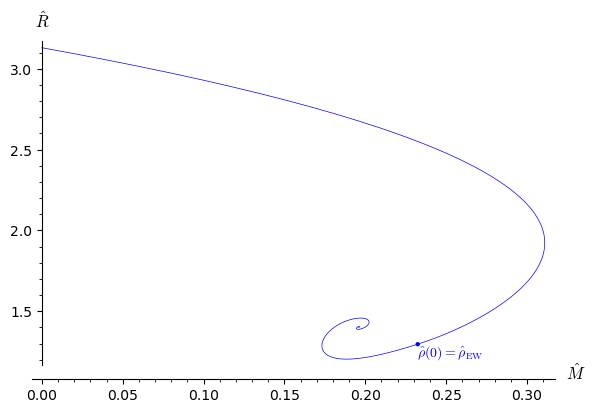

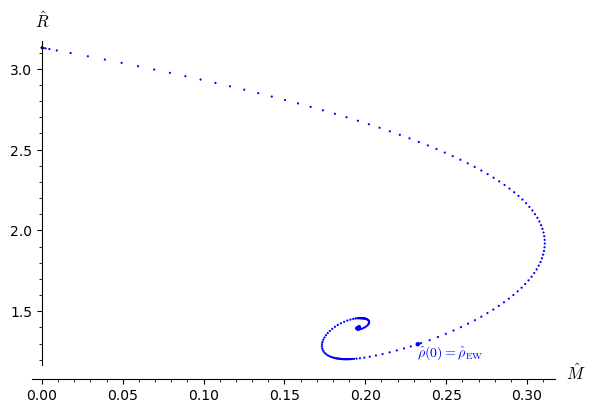

In [42]:
star_plot_joined = plots(stars,'mass','radius',joined=True)
#show(star_plot_joined,ymin=0,xmin=0)
plt=star_plot_joined
#plt.set_aspect_ratio(.05)
plt.set_axes_range(xmin=0,ymin=0)
plt.axes_labels([r"$\hat M$",r"$\hat R$"])
plt_bo1=plt
plt_bo2=plt
plt_bo0=plt
plt += point(EW)
plt += text(r"$\hat\rho(0) =\hat \rho_{\mathrm{EW}}$", (mass_EW+.02,radius_EW-.05),\
            fontsize='medium')
plt.axes_labels([r"$\hat M$",r"$\hat R$"])
plt.set_aspect_ratio(.1)
show(plt,axes_labels_size=1.2)
plt.save('plots/M_R.pdf',dpi=600,axes_labels_size=1.2)
#
star_plot_unjoined = plots(stars,'mass','radius',joined=False)
#show(star_plot_joined,ymin=0,xmin=0)
plt=star_plot_unjoined
#plt.set_aspect_ratio(.05)
plt.set_axes_range(xmin=0,ymin=0)
plt.axes_labels([r"$\hat M$",r"$\hat R$"])
plt_bo1_unj=plt
plt_bo2_unj=plt
plt_bo0_unj=plt
plt += point(EW)
plt += text(r"$\hat\rho(0) =\hat \rho_{\mathrm{EW}}$", (mass_EW+.02,radius_EW-.05),\
            fontsize='medium')
plt.axes_labels([r"$\hat M$",r"$\hat R$"])
plt.set_aspect_ratio(.1)
show(plt,axes_labels_size=1.2)

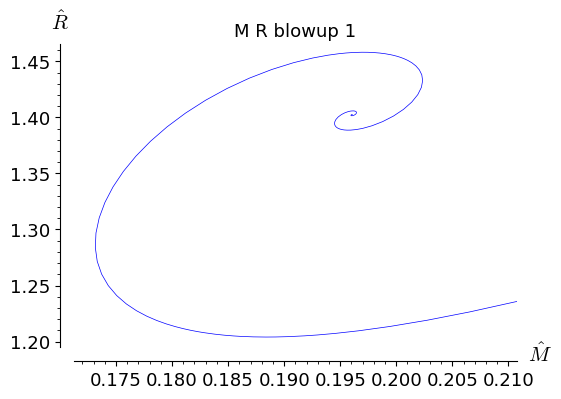

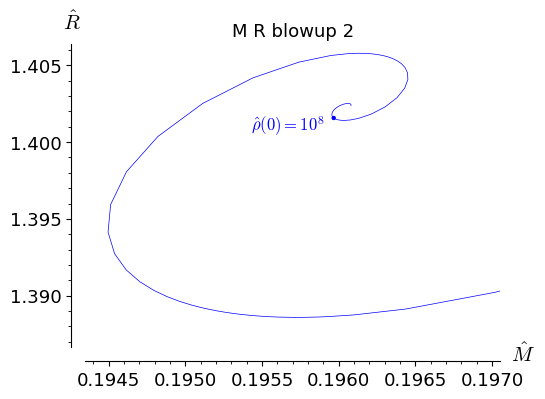

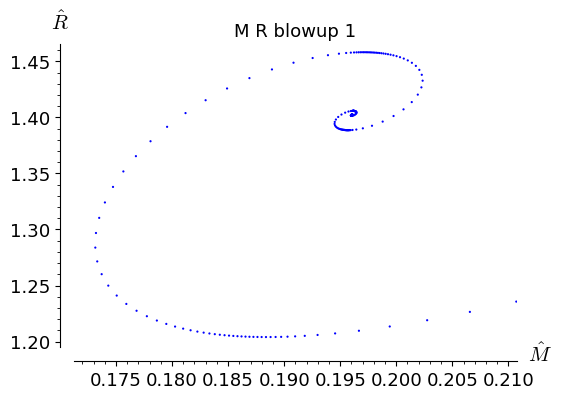

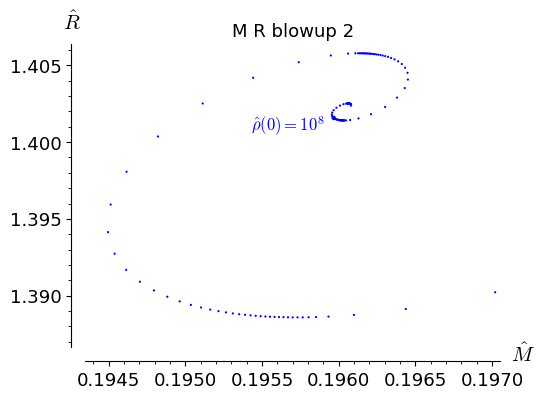

In [43]:
plt_bo1.set_aspect_ratio(.1)
plt_bo1.set_axes_range(xmin=0.172,xmax=.21,ymin=1.2,ymax=1.46)
show(plt_bo1,title="M R blowup 1",fontsize=13,axes_labels_size=1.2)
plt_bo1.save('plots/M_Rblowup1.pdf',dpi=600,fontsize=13,axes_labels_size=1.2)
#
plt_bo2 = plt_bo0
plt_bo2 += point(BSM)
plt_bo2 += text(r"$\hat\rho(0) =10^8$", (mass_BSM-0.0003,radius_BSM-.0005),fontsize='large')
plt_bo2.set_aspect_ratio(.1)
plt_bo2.set_axes_range(xmin=0.1944,xmax=.197,ymin=1.387,ymax=1.406)
plt_bo2.axes_labels([r"$\hat M$",r"$\hat R$"])
show(plt_bo2,title="M R blowup 2",fontsize=13,axes_labels_size=1.2)
plt_bo2.save('plots/M_Rblowup2.pdf',dpi=600,fontsize=13,axes_labels_size=1.2)
#
plt_bo1_unj.set_aspect_ratio(.1)
plt_bo1_unj.set_axes_range(xmin=0.172,xmax=.21,ymin=1.2,ymax=1.46)
show(plt_bo1_unj,title="M R blowup 1",fontsize=13,axes_labels_size=1.2)
#
plt_bo2_unj = plt_bo0_unj
plt_bo2_unj += point(BSM)
plt_bo2_unj += text(r"$\hat\rho(0) =10^8$", (mass_BSM-0.0003,radius_BSM-.0005),fontsize='large')
plt_bo2_unj.set_aspect_ratio(.1)
plt_bo2_unj.set_axes_range(xmin=0.1944,xmax=.197,ymin=1.387,ymax=1.406)
plt_bo2_unj.axes_labels([r"$\hat M$",r"$\hat R$"])
show(plt_bo2_unj,title="M R blowup 2",fontsize=13,axes_labels_size=1.2)

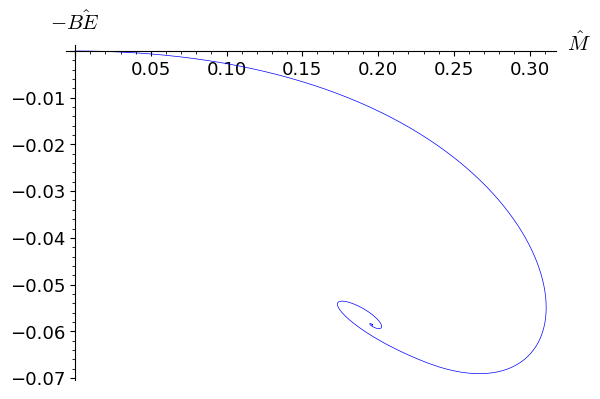

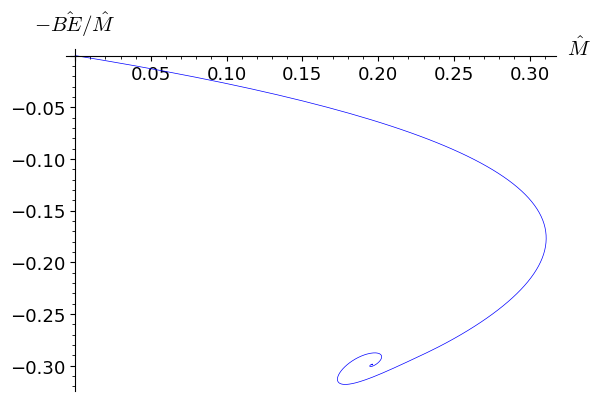

In [44]:
BElist = []
for central_density,star_data in stars.items():
    mass = star_data['mass']
    energy = star_data['energy']
    BE = energy-mass
    BE_ratio = (energy-mass)/mass
    BElist.append([mass,-BE])
plt = list_plot(BElist,marker=None,plotjoined=True,thickness=0.5)
#plt.set_axes_range(xmin=0,ymin=0)
plt.axes_labels([r"$\hat M$",r"$-\hat{BE}$"])
show(plt,fontsize=13,axes_labels_size=1.2)
plt.save('plots/M_BE.pdf',dpi=600,fontsize=13,axes_labels_size=1.2)
#
BEratiolist = []
for central_density,star_data in stars.items():
    mass = star_data['mass']
    energy = star_data['energy']
    BE_ratio = (energy-mass)/mass
    BEratiolist.append([mass,-BE_ratio])
plt = list_plot(BEratiolist,marker=None,plotjoined=True,thickness=0.5)
#plt.set_axes_range(xmin=0,ymin=0)
plt.axes_labels([r"$\hat M$",r"$-\hat{BE}/\hat{M}$"])
show(plt,fontsize=13,axes_labels_size=1.2)
plt.save('plots/M_BEratio.pdf',dpi=600,fontsize=13,axes_labels_size=1.2)


## Special stars

### The star of minumum radius.

3.20219250e+00 r=1.204027e+00 m=1.883777e-01 e=2.477540e-01 BE=5.937627e-02 BE/M=3.151979e-01 t=6

In [45]:
star_data_min_R =star_set[1]['3.20219250e+00']['data']
mass_min_R = myR(star_data_min_R['mass'])
radius_min_R = myR(star_data_min_R['radius'])
min_R = (mass_min_R,radius_min_R)
min_R

(0.18837772352835232517000, 1.2040273735813345141000)

### The star of largest mass

3.47709480e-01 r=1.896051e+00 m=3.108239e-01 e=3.670901e-01 BE=5.626628e-02 BE/M=1.810230e-01 t=12  
3.41803251e-01 r=1.918823e+00 m=3.109591e-01 e=3.661058e-01 BE=5.514674e-02 BE/M=1.773441e-01 t=12  
3.35874144e-01 r=1.941588e+00 m=3.108993e-01 e=3.648964e-01 BE=5.399716e-02 BE/M=1.736805e-01 t=12

In [46]:
for star_key in ['3.47709480e-01','3.41803251e-01','3.35874144e-01']:
    print(coreless_star_set[1][star_key]['ode']['initial value'])

0.34770947997778476825
0.34180325054452595958
0.335874143802153429


In [47]:
star_set_search_largest_m={}
for x in srange(0.336,0.347,.001,universe=RDF):
    x=Reals(round(x,4))
    star = make_coreless_star(x)
    star_data = star['data']
    star_key = star['star key']
    print_star(star_key,star_data)
    star_set_search_largest_m[star_key]=star

3.36000000e-01 r=1.941106e+00 m=3.109026e-01 e=3.649244e-01 BE=5.402181e-02 BE/M=1.737580e-01 t=0
3.37000000e-01 r=1.937273e+00 m=3.109256e-01 e=3.651430e-01 BE=5.421733e-02 BE/M=1.743739e-01 t=0
3.38000000e-01 r=1.933436e+00 m=3.109431e-01 e=3.653553e-01 BE=5.441216e-02 BE/M=1.749907e-01 t=0
3.39000000e-01 r=1.929598e+00 m=3.109551e-01 e=3.655614e-01 BE=5.460630e-02 BE/M=1.756083e-01 t=0
3.40000000e-01 r=1.925756e+00 m=3.109615e-01 e=3.657613e-01 BE=5.479974e-02 BE/M=1.762267e-01 t=0
3.41000000e-01 r=1.921912e+00 m=3.109624e-01 e=3.659549e-01 BE=5.499246e-02 BE/M=1.768460e-01 t=0
3.42000000e-01 r=1.918065e+00 m=3.109577e-01 e=3.661422e-01 BE=5.518446e-02 BE/M=1.774661e-01 t=0
3.43000000e-01 r=1.914216e+00 m=3.109474e-01 e=3.663231e-01 BE=5.537572e-02 BE/M=1.780871e-01 t=0
3.44000000e-01 r=1.910364e+00 m=3.109316e-01 e=3.664978e-01 BE=5.556624e-02 BE/M=1.787089e-01 t=0
3.45000000e-01 r=1.906509e+00 m=3.109101e-01 e=3.666661e-01 BE=5.575601e-02 BE/M=1.793316e-01 t=0
3.46000000e-01 r=1.9

In [48]:
star = star_set_search_largest_m['3.41000000e-01']
star_data = star['data']
mass = Reals(star_data['mass'])
radius = Reals(star_data['radius'])
energy = Reals(star_data['energy'])
BE = energy-mass
pretty_print(LE(r"\hat M = "),mass,LE(r"\qquad M = "),mass*m_b_kg,LE(r" = "),mass*m_b_solar,LE(r"M_\odot"))
pretty_print(LE(r"\hat R = "),radius,LE(r"\qquad R = "),radius*r_b_m)
pretty_print(LE(r"\frac{BE}{M} = "),BE/mass)

\hat M =  0.31096240159359108330000 \qquad M =  (1.8183901269497294e+25)*kg  =  9.14499158594714e-06 M_\odot

\hat R =  1.9219122503640596194000 \qquad R =  0.08345974544494067*m

\frac{BE}{M} =  0.17684600815657502834582

### The mass where transitions become possible
  
9.23643135e+00 r=1.271494e+00 m=1.733260e-01 e=2.278757e-01 BE=5.454964e-02 BE/M=3.147227e-01 t=6  
1.02705121e+01 r=1.283822e+00 m=1.731541e-01 e=2.274269e-01 BE=5.427287e-02 BE/M=3.134369e-01 t=6  
1.14397938e+01 r=1.296846e+00 m=1.732126e-01 e=2.272499e-01 BE=5.403726e-02 BE/M=3.119707e-01 t=6  

In [49]:
star_set_search_transition={}
for x in srange(9.24,11.43,.2,universe=RDF):
    x=Reals(round(x,4))
    star = make_star(x)
    star_data = star['data']
    star_key = star['star key']
    print_star(star_key,star_data)
    star_set_search_transition[star_key]=star

9.24000000e+00 r=1.271538e+00 m=1.733250e-01 e=2.278735e-01 BE=5.454855e-02 BE/M=3.147183e-01 t=0
9.44000000e+00 r=1.273979e+00 m=1.732717e-01 e=2.277609e-01 BE=5.448919e-02 BE/M=3.144725e-01 t=0
9.64000000e+00 r=1.276393e+00 m=1.732288e-01 e=2.276616e-01 BE=5.443281e-02 BE/M=3.142249e-01 t=0
9.84000000e+00 r=1.278779e+00 m=1.731956e-01 e=2.275748e-01 BE=5.437924e-02 BE/M=3.139759e-01 t=0
1.00400000e+01 r=1.281138e+00 m=1.731714e-01 e=2.274998e-01 BE=5.432836e-02 BE/M=3.137259e-01 t=0
1.02400000e+01 r=1.283469e+00 m=1.731558e-01 e=2.274358e-01 BE=5.428003e-02 BE/M=3.134752e-01 t=0
1.04400000e+01 r=1.285771e+00 m=1.731480e-01 e=2.273822e-01 BE=5.423413e-02 BE/M=3.132240e-01 t=0
1.06400000e+01 r=1.288044e+00 m=1.731478e-01 e=2.273384e-01 BE=5.419054e-02 BE/M=3.129727e-01 t=0
1.08400000e+01 r=1.290289e+00 m=1.731546e-01 e=2.273037e-01 BE=5.414916e-02 BE/M=3.127215e-01 t=0
1.10400000e+01 r=1.292504e+00 m=1.731679e-01 e=2.272778e-01 BE=5.410987e-02 BE/M=3.124706e-01 t=0
1.12400000e+01 r=1.2

In [50]:
star = star_set_search_transition['1.06400000e+01']
star_data = star['data']
mass = Reals(star_data['mass'])
radius = Reals(star_data['radius'])
energy = Reals(star_data['energy'])
BE = energy-mass
pretty_print(LE(r"\hat M = "),mass,LE(r"\qquad M = "),mass*m_b_kg,LE(r" = "),mass*m_b_solar,LE(r"M_\odot"))
pretty_print(LE(r"\hat R = "),radius,LE(r"\qquad R = "),radius*r_b_m)
pretty_print(LE(r"\frac{BE}{M} = "),BE/mass)

\hat M =  0.17314781111503715215000 \qquad M =  (1.0125026968566777e+25)*kg  =  5.092047358965388e-06 M_\odot

\hat R =  1.2880442749896468792000 \qquad R =  0.05593379577662084*m

\frac{BE}{M} =  0.31297271924251858054214

### The star of largest $\mathrm{BE}/M$

In [51]:
star_set_search={}
for x in srange(5.21,5.30,.01,universe=RDF):
    x=Reals(round(x,4))
    star = make_star(x)
    star_data = star['data']
    star_key = star['star key']
    print_star(star_key,star_data)
    star_set_search[star_key]=star

5.21000000e+00 r=1.219663e+00 m=1.784181e-01 e=2.351704e-01 BE=5.675226e-02 BE/M=3.180858e-01 t=0
5.22000000e+00 r=1.219782e+00 m=1.783891e-01 e=2.351322e-01 BE=5.674309e-02 BE/M=3.180861e-01 t=0
5.23000000e+00 r=1.219902e+00 m=1.783602e-01 e=2.350941e-01 BE=5.673395e-02 BE/M=3.180864e-01 t=0
5.24000000e+00 r=1.220022e+00 m=1.783314e-01 e=2.350563e-01 BE=5.672484e-02 BE/M=3.180866e-01 t=0
5.25000000e+00 r=1.220142e+00 m=1.783028e-01 e=2.350186e-01 BE=5.671576e-02 BE/M=3.180867e-01 t=0
5.26000000e+00 r=1.220262e+00 m=1.782743e-01 e=2.349810e-01 BE=5.670670e-02 BE/M=3.180868e-01 t=0
5.27000000e+00 r=1.220383e+00 m=1.782460e-01 e=2.349436e-01 BE=5.669767e-02 BE/M=3.180867e-01 t=0
5.28000000e+00 r=1.220503e+00 m=1.782177e-01 e=2.349064e-01 BE=5.668867e-02 BE/M=3.180866e-01 t=0
5.29000000e+00 r=1.220624e+00 m=1.781896e-01 e=2.348693e-01 BE=5.667970e-02 BE/M=3.180864e-01 t=0


In [52]:
star = star_set_search['5.26000000e+00']
star_data = star['data']
mass = Reals(star_data['mass'])
radius = Reals(star_data['radius'])
energy = Reals(star_data['energy'])
BE = energy-mass
pretty_print(LE(r"\hat M = "),mass,LE(r"\qquad M = "),mass*m_b_kg,LE(r" = "),mass*m_b_solar,LE(r"M_\odot"))
pretty_print(LE(r"\hat R = "),radius,LE(r"\qquad R = "),radius*r_b_m)
pretty_print(LE(r"\frac{BE}{M} = "),BE/mass)

\hat M =  0.17827431985146075410000 \qquad M =  (1.0424805746459594e+25)*kg  =  5.24281117806256e-06 M_\odot

\hat R =  1.2202620922647479658000 \qquad R =  0.05299032959347387*m

\frac{BE}{M} =  0.31808676121034497896813

## Not used in the paper

### radius / Schwarzschild radius

In [53]:
Rratiolist = []
for central_density,star_data in stars.items():
    mass = star_data['mass']
    radius = star_data['radius']
    Rratiolist.append([mass,radius/(2*mass)])
plt = list_plot(Rratiolist,marker=None,plotjoined=True,thickness=0.5)


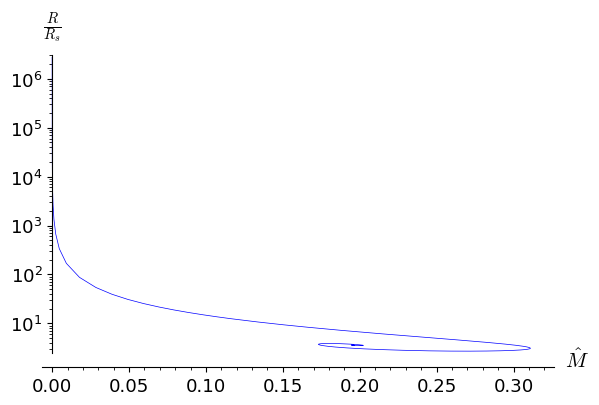

In [54]:
plt.set_axes_range(xmin=0,xmax=0.32)
plt.axes_labels([r"$\hat M$",r"$\frac{R}{R_s}$"])
show(plt,fontsize=13,axes_labels_size=1.2,scale="semilogy")
#plt.save('plots/M_BEratio.pdf',dpi=600,fontsize=13,axes_labels_size=1.2)


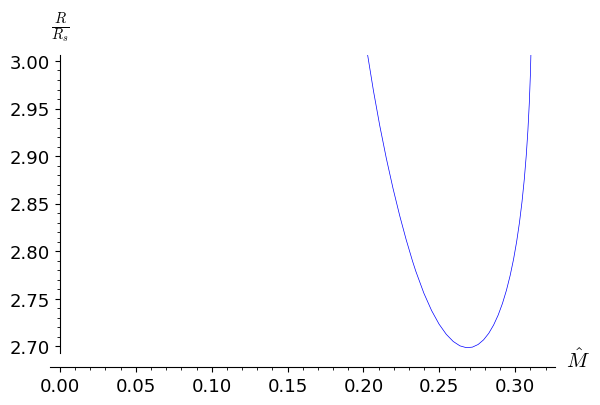

In [55]:
plt.set_axes_range(xmin=0,xmax=0.32,ymax=3)
plt.axes_labels([r"$\hat M$",r"$\frac{R}{R_s}$"])
show(plt,fontsize=13,axes_labels_size=1.2)


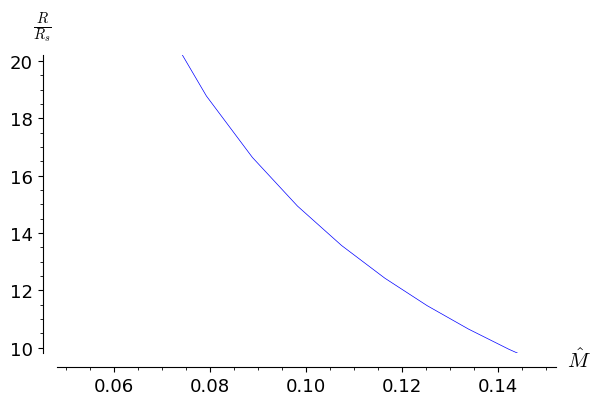

In [56]:
plt.set_axes_range(xmin=0.05,xmax=0.15,ymin=10,ymax=20)
plt.axes_labels([r"$\hat M$",r"$\frac{R}{R_s}$"])
show(plt,fontsize=13,axes_labels_size=1.2)


### Core radius / radius and core mass / mass

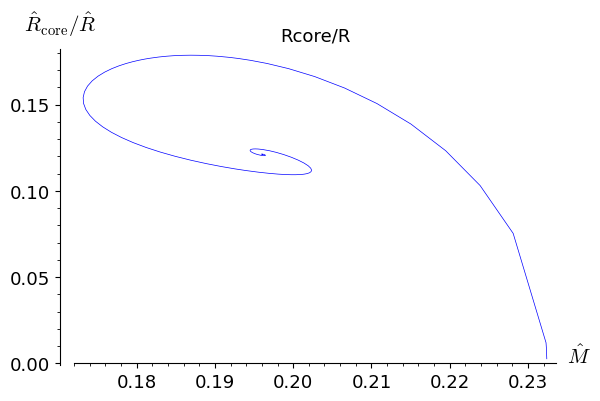

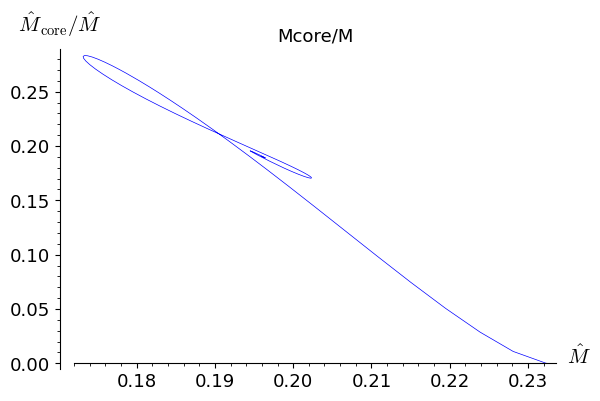

In [57]:
core_radius_ratios = []
for central_density,star_data in cored_stars.items():
    mass = star_data['mass']
    core_radius_ratio = star_data['core radius']/star_data['radius']
    core_radius_ratios.append([mass,core_radius_ratio])
#list_plot(core_radius_ratios,marker='.',size=10)
plt = list_plot(core_radius_ratios,marker=None,plotjoined=True,thickness=0.5)
#plt.set_axes_range(xmin=0,ymin=0)
plt.axes_labels([r"$\hat M$",r"${\hat R_{\mathrm{core}}}/{\hat R}$"])
show(plt,title="Rcore/R",fontsize=13,axes_labels_size=1.2)
plt.save('plots/M_Rcoreratio.pdf',dpi=600,fontsize=13,axes_labels_size=1.2)
#
core_mass_ratios = []
for central_density,star_data in cored_stars.items():
    mass = star_data['mass']
    core_mass_ratio = star_data['core mass']/star_data['mass']
    core_mass_ratios.append([mass,core_mass_ratio])
plt = list_plot(core_mass_ratios,marker=None,plotjoined=True,thickness=0.5)
plt.axes_labels([r"$\hat M$",r"${\hat M_{\mathrm{core}}}/{\hat M}$"])
show(plt,title="Mcore/M",fontsize=13,axes_labels_size=1.2)
plt.save('plots/M_Mcoreratio.pdf',dpi=600,fontsize=13,axes_labels_size=1.2)
#list_plot(core_mass_ratios,marker='.',size=10)


### mass profile of a cloud

'mp.dps = ' 30 '   mp decimal precision = ' 31 '     sage decimal precision = ' 34

'mp.dps = ' 20 '   mp decimal precision = ' 21 '     sage decimal precision = ' 24

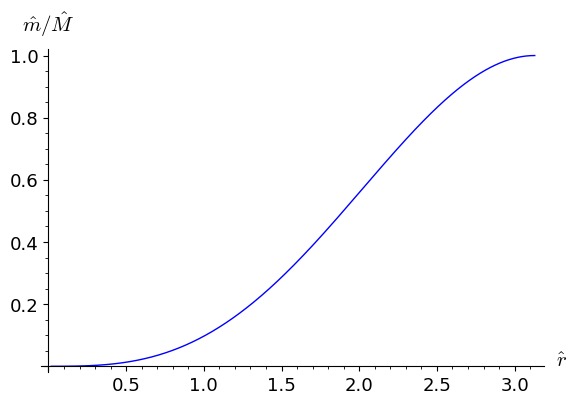

In [58]:
set_precision(30)
star = make_coreless_star(3.0517578125e-7,return_ode=True)
ode = star['ode']
star_data = star['data']
shell_ode = ode['shell ode']
initial_value = ode['initial value']
mass = star_data['mass']
#
r_fun = lambda m: Reals(shell_ode(m)[0])
m_fun = lambda m: Reals(shell_ode(m)[1]/mass)
plt = parametric_plot((r_fun,m_fun),(m,0,initial_value))
#
set_precision()
#
plt.set_aspect_ratio(2)
plt.axes_labels([r"$\hat r$",r"$\hat m/\hat M$"])
show(plt,fontsize=13,axes_labels_size=1.2)

### mass profiles of massive stars
  
3 stars of same mass, different radius and binding energy

1.19892328e-01 r=2.721241e+00 m=1.812195e-01 e=1.913617e-01 BE=1.014224e-02 BE/M=5.596662e-02 t=12  
2.86784664e+01 r=1.403815e+00 m=1.812014e-01 e=2.350428e-01 BE=5.384138e-02 BE/M=2.971356e-01 t=6  
4.47166984e+00 r=1.211533e+00 m=1.809907e-01 e=2.385063e-01 BE=5.751560e-02 BE/M=3.177822e-01 t=6  

In [59]:
star_key1 = '1.19892328e-01'
star1 = coreless_star_set[1][star_key1]
star_key2 = '2.86784664e+01'
star2 = star_set[1][star_key2]
star_key3 = '4.47166984e+00'
star3 = star_set[1][star_key3]
print(star1['ode']['initial value'])
print(star2['ode']['initial value'])
print(star3['ode']['initial value'])

0.11989232813047308982
28.678466396330248299
4.4716698404048722934


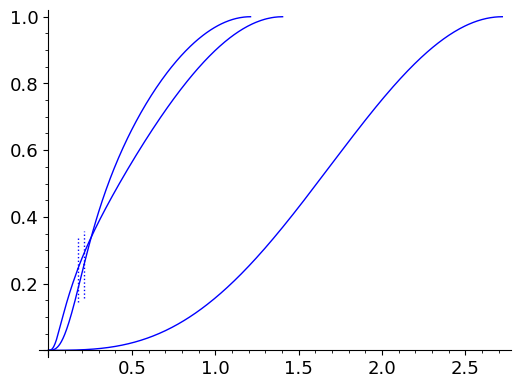

In [60]:
star1 = make_coreless_star(0.11989232813047308982,return_ode=True)
star2 = make_star(28.678466396330248299,return_ode=True)
star3 = make_star(4.4716698404048722934,return_ode=True)
star_key1 = '1.19892328e-01'
star_key2 = '2.86784664e+01'
star_key3 = '4.47166984e+00'

star_key = star_key1
star = star1
ode = star['ode']
star_data = star['data']
shell_ode = ode['shell ode']
initial_value = ode['initial value']
mass = star_data['mass']
#
r_fun = lambda m: Reals(shell_ode(m)[0])
m_fun = lambda m: Reals(shell_ode(m)[1]/mass)
plt1 = parametric_plot((r_fun,m_fun),(m,0,initial_value))
#
plt1.set_aspect_ratio(2)
plt1.axes_labels([r"$\hat r$",r"$\hat m/\hat M$"])
#show(plt,fontsize=13,axes_labels_size=1.2)

star_key = star_key2
star = star2
ode = star['ode']
star_data = star['data']
shell_ode = ode['shell ode']
core_ode = ode['core ode']
initial_value = ode['initial value']
mass = star_data['mass']
#
rhoh = var('rhoh')
core_r = lambda rhoh: Reals(core_ode(rhoh)[0])
core_m = lambda rhoh: Reals(core_ode(rhoh)[1]/mass)
bdry = core_ode(1)
r_bdry =  Reals(bdry[0])
m_bdry = Reals(bdry[1])/mass
plt_core = parametric_plot((core_r,core_m),(rhoh,1,initial_value))
plt_core += line([(r_bdry,m_bdry-.1),(r_bdry,m_bdry+.1)],linestyle=":")
#show(plt_core)
#
r_fun = lambda m: Reals(shell_ode(m)[0])
m_fun = lambda m: Reals(shell_ode(m)[1]/mass)
plt = parametric_plot((r_fun,m_fun),(m,0,0.5))
plt2 = plt+plt_core
#
plt2.set_aspect_ratio(2)
plt2.axes_labels([r"$\hat r$",r"$\hat m/\hat M$"])
#show(plt2,fontsize=13,axes_labels_size=1.2)

star_key = star_key3
star = star3
ode = star['ode']
star_data = star['data']
shell_ode = ode['shell ode']
core_ode = ode['core ode']
initial_value = ode['initial value']
mass = star_data['mass']
#
rhoh = var('rhoh')
core_r = lambda rhoh: Reals(core_ode(rhoh)[0])
core_m = lambda rhoh: Reals(core_ode(rhoh)[1]/mass)
bdry = core_ode(1)
r_bdry =  Reals(bdry[0])
m_bdry = Reals(bdry[1])/mass
plt_core = parametric_plot((core_r,core_m),(rhoh,1,initial_value))
plt_core += line([(r_bdry,m_bdry-.1),(r_bdry,m_bdry+.1)],linestyle=":")
#show(plt_core)
#
r_fun = lambda m: Reals(shell_ode(m)[0])
m_fun = lambda m: Reals(shell_ode(m)[1]/mass)
plt = parametric_plot((r_fun,m_fun),(m,0,0.5))
plt3 = plt+plt_core
#
plt3.set_aspect_ratio(2)
plt3.axes_labels([r"$\hat r$",r"$\hat m/\hat M$"])
#show(plt3,fontsize=13,axes_labels_size=1.2)

show(plt1+plt2+plt3,fontsize=13,axes_labels_size=1.2)